<a href="https://colab.research.google.com/github/chinge55/Poem-Generator/blob/main/Simple_Embedding_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/devkotasawal1/Poem-Generator

Cloning into 'Poem-Generator'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Unpacking objects: 100% (10/10), 3.89 MiB | 1.69 MiB/s, done.


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os

In [3]:
path_to_file = "Poem-Generator/combined.txt"

In [4]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 119162 characters


In [5]:
print(text[:250])

नछाडी जानोस् हे मेरा प्राण ! अकेली मलाई,
मनको वनमा ननिभ्ने गरी विरह जलाई !
ननिभ्ने गरी विरह जलाई,
लोचनका तारा ! हे मेर प्यारा ! यो जोति  बिलाए !
के भनूँ? भन्ने म केही थिइन  विष नै पिलाए !
प्यारा ! विष नै पिलाए !
मनको कुरा गलामा अड्छ, अड्कन्छ गलामा,
य


In [6]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

74 unique characters


In [7]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [8]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  ',' :   3,
  '.' :   4,
  ':' :   5,
  ';' :   6,
  '?' :   7,
  'ँ' :   8,
  'ं' :   9,
  'ः' :  10,
  'अ' :  11,
  'आ' :  12,
  'इ' :  13,
  'ई' :  14,
  'उ' :  15,
  'ऊ' :  16,
  'ऋ' :  17,
  'ए' :  18,
  'ऐ' :  19,
  ...
}


In [9]:
# Show how the first 13 characters from the text are mapped to integers
print('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'नछाडी जानोस् ' ---- characters mapped to int ---- > [41 28 55 34 57  1 29 55 41 63 53 65  1]


In [10]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length + 1)
examples_per_epoch

1179

In [11]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

न
छ
ा
ड
ी


In [12]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'नछाडी जानोस् हे मेरा प्राण ! अकेली मलाई,\nमनको वनमा ननिभ्ने गरी विरह जलाई !\nननिभ्ने गरी विरह जलाई,\nलोच'
'नका तारा ! हे मेर प्यारा ! यो जोति  बिलाए !\nके भनूँ? भन्ने म केही थिइन  विष नै पिलाए !\nप्यारा ! विष न'
'ै पिलाए !\nमनको कुरा गलामा अड्छ, अड्कन्छ गलामा,\nयो मेरो मुटु पचासबाजी धड्कन्छ पलामा ।\nयो छाती मेरो चिर'
'ेर खोली नजर गराए,\nत्यो मन केही फर्कंदो होला, तस्विर खुलाए\nआँसुमा खस्छ मनको टुक्रा यो आँसु बोल्दैन,\nमन'
'को कुरा मनमै बस्छ, छातिले खोल्दैन,\nप्यारा ! आँसुले बोल्दैन !\nहे मेरी मुना ! नभन त्यसो, जूनमा फुलेकी !'


In [13]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [14]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'नछाडी जानोस् हे मेरा प्राण ! अकेली मलाई,\nमनको वनमा ननिभ्ने गरी विरह जलाई !\nननिभ्ने गरी विरह जलाई,\nलो'
Target data: 'छाडी जानोस् हे मेरा प्राण ! अकेली मलाई,\nमनको वनमा ननिभ्ने गरी विरह जलाई !\nननिभ्ने गरी विरह जलाई,\nलोच'


In [15]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [16]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024
vocab_size

74

In [17]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [18]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [19]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 74) # (batch_size, sequence_length, vocab_size)


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           18944     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 74)            75850     
Total params: 4,033,098
Trainable params: 4,033,098
Non-trainable params: 0
_________________________________________________________________


In [21]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [22]:
sampled_indices

array([ 7, 72, 57, 50, 10, 38, 56, 15, 49,  4, 63, 40, 26, 73, 70, 59, 65,
       65, 10, 38, 49,  0, 61, 69, 59, 49, 64, 15, 34, 27, 20, 66, 44,  4,
       33, 32, 62, 19, 36, 39, 45, 31, 32, 54, 49, 54, 56, 20, 61, 38, 61,
       69, 45, 59, 16, 68, 49, 73, 63, 37, 66, 29,  8, 65, 59,  5, 29, 47,
       63, 54, 41,  1, 23, 14,  2, 37, 12, 11, 59, 65, 63, 16, 65, 12, 58,
       26, 29, 64,  4, 16, 62, 43, 26, 26, 66, 31, 57, 40,  9, 60])

In [23]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 '!\nकस्तो कल्पिनसक्नु सुन्दर\nहोला त्यो ?\nराम्रो सम्झी हामी रुन्छौँ\nअवनीमा !\nहाम्रा कणझैं देख्छौ तारा,\n'

Next Char Predictions: 
 '?“ीवःथिउल.ोधङ”‘ू््ःथल\nे–ूलौउडचओॐब.ठटैऐणदभञटहलहिओेथे–भूऊ\u200dल”ोतॐजँ्ू:जयोहन खई!तआअू्ोऊ्आुङजौ.ऊैफङङॐञीधंृ'


In [24]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 74)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.304136


In [25]:
model.compile(optimizer='adam', loss=loss, metrics = ['acc'])

In [26]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [27]:
EPOCHS = 50

In [28]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/50
18/18 [==============================] - 2s 59ms/step - loss: 4.4969 - acc: 0.1044
Epoch 2/50
18/18 [==============================] - 1s 57ms/step - loss: 3.5879 - acc: 0.1222
Epoch 3/50
18/18 [==============================] - 1s 57ms/step - loss: 3.1824 - acc: 0.2151
Epoch 4/50
18/18 [==============================] - 1s 58ms/step - loss: 2.8584 - acc: 0.2574
Epoch 5/50
18/18 [==============================] - 1s 58ms/step - loss: 2.7361 - acc: 0.2714
Epoch 6/50
18/18 [==============================] - 1s 60ms/step - loss: 2.6689 - acc: 0.2801
Epoch 7/50
18/18 [==============================] - 1s 59ms/step - loss: 2.6333 - acc: 0.2852
Epoch 8/50
18/18 [==============================] - 1s 60ms/step - loss: 2.5939 - acc: 0.2921
Epoch 9/50
18/18 [==============================] - 1s 61ms/step - loss: 2.5579 - acc: 0.3025
Epoch 10/50
18/18 [==============================] - 1s 60ms/step - loss: 2.5265 - acc: 0.3069
Epoch 11/50
18/18 [==============================] - 1s 59m

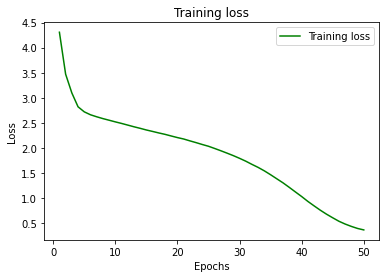

In [29]:
loss_train = history.history['loss']
epochs = range(1,len(history.history['acc'])+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [31]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_50'

In [32]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [35]:
print(generate_text(model, start_string="हे मेरी मुना"))

हे मेरी मुना !! ओहार्छ !
म महिता ! प्रतिडे म !
मुस्किनौ ?
मुस्की बनैन्, तिनमा पाइन्न !’
‘सजी कणु लिन्छुमा गुँजगुल बन्नेका रे !
सूनसान भो त्रासले मुस्काँला अब, सुवारि सिथरी–मुसबाई तान्छ तिमी नै,
मोटीहरुमा गाता भएर यो !
बच्चाहरुको सूत्र सर्खीभित्र माति नभेख्तो ल्या।
फूल कहान्या होइन यो त !
ति सो आमा ! ए युवता गुणा भए,
सिथी शङ्का–नापी जनी,
बजापहरूको हातमा !
कलाको राम्रो हजूरको पाउन ल्यो केव दुःखीन् तीबाली
सम्झँदाहरुको सङ्गारको यो आदूभरूली,
ढलक्मको डडल होला श्रीज भिलाको
विरमज्री, ढल्क्यो प्रलय गर्दैन !
चाहन्छौँ हुन, भोरिजो यतीको मुटु पङ्खले छ्ँदैन !
पुछनध्यौ  आँसु न ।
‘जुनुला हर्‍यौ किमी क्या ली !
बुज्रुक्ष तल्पे मिलिई देव्य सिरमाथि
भएर आँशुको नजर ।
मदनशी त्यो बिच्ति छ मानव ह्लासा लगतमा गुलेको !
मलाई माग चाहियो ! म दृष्टा लगन ! हा ! म !
घर !
बुझाउँछे मन !
शीघ्र शेरका दृग जाल छ !
म मूर्छिन बादल ।
मीठो दे भन्छु याग्यो आकाश रथाई,
कलेजाका लीवन अभो ठोला दियो छुमादित नि ज्ञान ।
आखीर शूल गर्दछिइन् ।
 हे पिनका मना–दिनले प्रतिभा प्रभातमा ।
कलिलो तिम्रो शरीरमा काँचेको ।
विकारको एर मुसाडझूफ चिन्छु वै